In [1]:
from numpy import genfromtxt
from PIL import Image, ImageDraw, ImageChops
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt
from skimage.morphology import binary_opening, binary_closing,binary_erosion, rectangle, binary_dilation, disk
from skimage.segmentation import find_boundaries


# From Converted RJPEG To Temperature csv

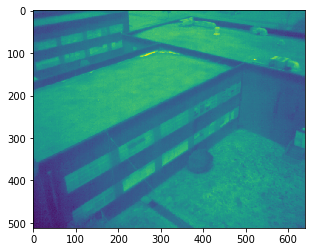

In [200]:
#thermal_tab = genfromtxt("/Users/stouzani/Google Drive/LBL-drone-thermal-project/Drone_Images_December2019/Thermal/DJI_0351.jpg", delimiter=',')
thermal_tab = genfromtxt('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/Thermal_preproc/DJI_0351.csv', delimiter=',')

# thermal_tab = np.rot90(thermal_tab,3)
# exclude the bottom right column because of some noise
# thermal_tab = thermal_tab[0:147,0:485]
plt.figure()
plt.imshow(thermal_tab)

In [201]:
thermal_tab.shape

(512, 640)

In [202]:
np.amax(thermal_tab)

21.2291009283138

In [203]:
np.amin(thermal_tab)

14.5837193140449

# Load mask json/npy

In [204]:
# mask_json = json.load(open('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Veracruz/masks_thm/DJI_0490_2.json'))

In [205]:
# objects = mask_json.get("objects")[0]

In [206]:
# points_lab = objects['points']

In [207]:
# nested_lists = points_lab['exterior']

In [208]:
# mask_polygon = [tuple(l) for l in nested_lists]

In [209]:
# def getMask(original,polygon):
#     #Returns the mask of the polygon
#     mask = Image.new('L', (original.shape[1],original.shape[0]), 0)
#     mask_draw = ImageDraw.Draw(mask)
#     mask_draw.polygon(polygon, outline=1, fill=1)
#     return np.array(mask, dtype=bool)

In [210]:
# mask = getMask(thermal_tab,mask_polygon)

In [211]:
# mask.shape

In [212]:
# plt.figure()
# plt.imshow(mask)

In [286]:
mask = np.load('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/masks_thm/DJI_0351.npy')
mask = np.array(mask, dtype=bool)

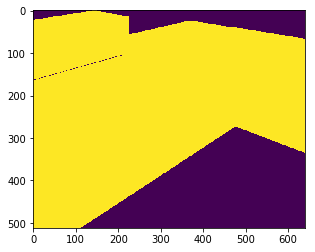

In [287]:
plt.figure()
plt.imshow(mask)

In [215]:
pixel_values = thermal_tab.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
pixel_values.shape

(327680, 1)

In [216]:
mask_pixel_values = mask.reshape((-1, 1))
mask_pixel_values.shape

(327680, 1)

In [217]:
pixel_values_croped = pixel_values[mask_pixel_values].reshape((-1, 1))
#pixel_values_croped = pixel_values.reshape((-1, 1))
pixel_values_croped.shape

(229475, 1)

In [218]:
pixel_values_croped

array([[17.400322],
       [17.468004],
       [17.17438 ],
       ...,
       [15.990894],
       [16.036682],
       [16.128195]], dtype=float32)

In [219]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [220]:
# number of clusters (K)
k = 16
_, labels, (centers) = cv2.kmeans(pixel_values_croped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [223]:
# convert back to 8 bit values
centers = np.int8(centers)

# flatten the labels array
labels = labels.flatten()

In [225]:
# convert all pixels to the color of the centroids
segmented_image_copped = centers[labels.flatten()]

In [226]:
segmented_image_copped.shape

(229475, 1)

In [227]:
segmented_image_copped.dtype

dtype('int8')

In [230]:
segmented_image = 10+np.zeros(pixel_values.shape, dtype=int)#pixel_values.astype(np.int8)

In [234]:
segmented_image[mask_pixel_values]  = segmented_image_copped[:,0]

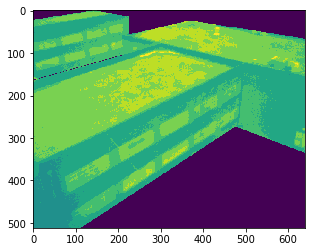

In [260]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(thermal_tab.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [274]:
# segmented_image_1 = Image.fromarray(np.float32(segmented_image))

In [275]:
# segmented_image_1 = segmented_image_1.convert("RGBA")
# segmented_image_1

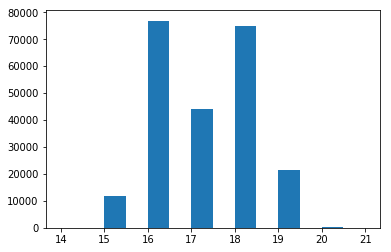

((array([    0.,     0., 11783.,     0., 76854.,     0., 44051.,     0.,
         74877.,     0., 21566.,     0.,   344.,     0.]),
  array([14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
         19.5, 20. , 20.5, 21. ]),
  <a list of 14 Patch objects>),
 None)

In [303]:
from matplotlib import pyplot as plt

# x = np.random.randint(25,100,25)
# y = np.random.randint(175,255,25)
# z = np.hstack((x,y))
# z = z.reshape((50,1))
# z = np.float32(z)
plt.hist(segmented_image_copped,14,[14,21]),plt.show()
# plt.hist(pixel_values_croped,14,[14,21]),plt.show()

# plt.hist(pixel_values,20,[18,22]),plt.show()


In [238]:
segmented_image_f = np.float32(segmented_image)
# segmented_image_f = np.float32(thermal_tab)

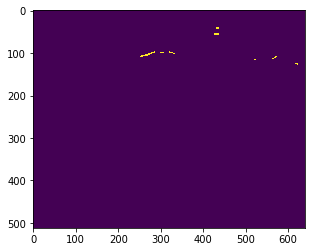

In [299]:
# th = cv2.threshold(segmented_image_f,19.5,255,cv2.THRESH_BINARY)[1]
th = cv2.threshold(segmented_image_f,19.5,255,cv2.THRESH_BINARY_INV)[1]
thresholded = th.astype(np.uint8)
thresholded = np.invert(thresholded)
plt.figure()
plt.imshow(thresholded)

In [300]:
# morphological operation
thresholded = binary_dilation(thresholded, rectangle(1,5))

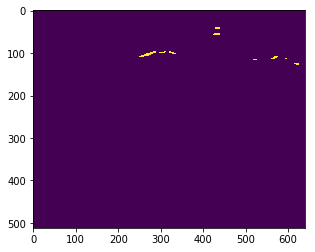

In [301]:
plt.figure()
plt.imshow(thresholded)

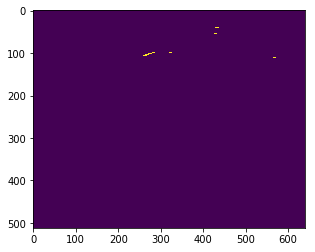

In [298]:
# thresholded = binary_erosion(thresholded, rectangle(5,1))
# plt.figure()
# plt.imshow(thresholded)

In [243]:
thresholded_2 = thresholded.astype(np.uint8)
contours, hierarchy = cv2.findContours(thresholded_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Create RGB images

In [244]:
thermal_im = 255*(thermal_tab - np.min(thermal_tab))/np.ptp(thermal_tab).astype(int)

In [245]:
thermal_im = cv2.cvtColor(thermal_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)

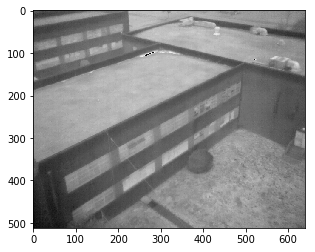

In [246]:
plt.figure()
plt.imshow(thermal_im)

In [247]:
mask = np.zeros(thermal_im.shape, np.uint8)
borders_im = cv2.drawContours(mask, contours, -1, (255,0,0),3)

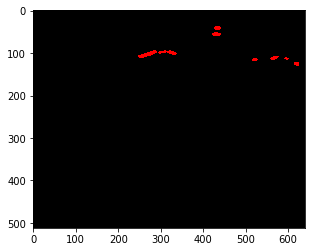

In [248]:
plt.figure()
plt.imshow(borders_im)

#### superimpose images


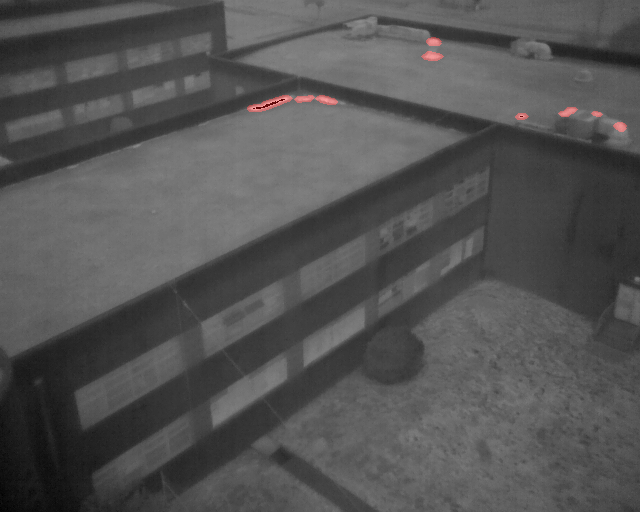

In [249]:
thermal_im_1 = Image.fromarray(thermal_im)
borders_im_1 = Image.fromarray(borders_im)
thermal_im_1 = thermal_im_1.convert("RGBA")
borders_im_1 = borders_im_1.convert("RGBA")
new_img = Image.blend(thermal_im_1, borders_im_1, 0.35)
new_img

In [251]:
new_img.save('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/Thermal_preproc/detected_leaks_DJI_0351.png')


In [284]:

segmented_image_0 = segmented_image
segmented_image_0[np.where(np.logical_not(mask))] =0
mask.shape

(512, 640, 3)

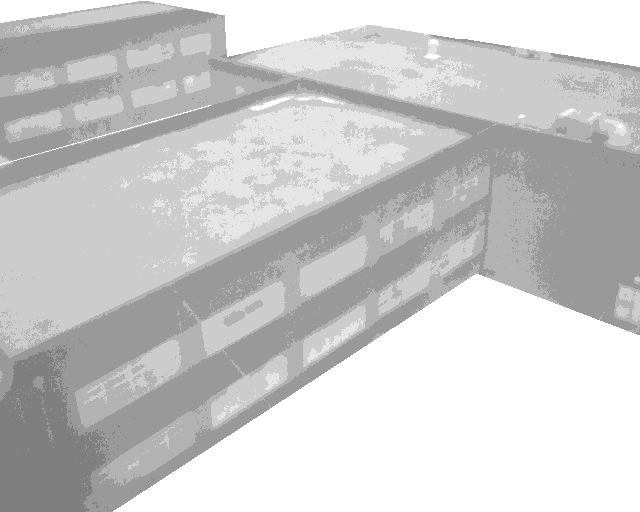

In [293]:
mask = np.load('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/masks_thm/DJI_0351.npy')
mask = np.array(mask, dtype=bool)
segmented_image_1 = Image.fromarray(np.float32(segmented_image))
segmented_image_im = 255*(segmented_image_1 - np.min(segmented_image_1))/np.ptp(segmented_image_1).astype(int)
segmented_image_im = cv2.cvtColor(segmented_image_im.astype(np.uint8),cv2.COLOR_GRAY2RGB)
crop_color = (255, 255, 255)
segmented_image_im[np.where(np.logical_not(mask))] = crop_color
segmented_image_im = Image.fromarray(segmented_image_im)
segmented_image_im = segmented_image_im.convert("RGBA")
segmented_image_im

In [294]:
segmented_image_im.save('/Users/stouzani/Desktop/Unstructured_ML/Drone/Drone_Data_Capture/Alameda_December_2019/Thermal_preproc/quantized_DJI_0351.png')


In [ ]:
def crop_image_outside_building(image, merged_polygons, offset, pmatrix):
    crop_color = (0.0, 0.0, 0.0, 0.0)
    im_shape = np.array(image).shape
    cropped_image = np.array(image)
    mask = np.zeros(im_shape[:2], dtype=np.uint8)

    for i in range(len(merged_polygons)):
        polygon = merged_polygons[i]
        projected_facades = get_projected_facades(polygon, pmatrix, offset=offset)
        poly_mask = get_polygon_mask(im_shape, projected_facades)
        mask[np.where(poly_mask)] = 1

    cropped_image[np.where(np.logical_not(mask))] = crop_color
    cropped_image = Image.fromarray(cropped_image, 'RGBA')
    return cropped_image